In [7]:
#@title
import matplotlib.pyplot as plt
import warnings

def logsumexp(arr, axis=0):
    """Computes the sum of arr assuming arr is in the log domain.
    Returns log(sum(exp(arr))) while minimizing the possibility of
    over/underflow.
    """
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    if vmax.ndim > 0:
        vmax[~np.isfinite(vmax)] = 0
    elif not np.isfinite(vmax):
        vmax = 0
    with np.errstate(divide="ignore"):
        out = np.log(np.sum(np.exp(arr - vmax), axis=0))
        out += vmax
        return out

def pcolormesh(matrix, title):
    plt.pcolormesh(matrix.T)
    plt.title(title)
    plt.ylabel('state')
    plt.xlabel('time step')
    plt.yticks(np.arange(matrix.shape[1]) + .5, range(matrix.shape[1]))
    plt.xticks(np.arange(0, matrix.shape[0], 10) + .5, range(0, matrix.shape[0], 10))

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [8]:
#@title
import numpy as np

###################
# Data and models #
###################

def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """
    M1 = len(hmm1['startprob']) - 1
    M2 = len(hmm2['startprob']) - 1
    K = M1 + M2

    hmm_concat = {
        'name': hmm1['name'] + hmm2['name'],
        'startprob': np.zeros(K+1),
        'transmat': np.zeros((K+1, K+1)),
        'means': np.concatenate((hmm1['means'], hmm2['means'])),
        'covars': np.concatenate((hmm1['covars'], hmm2['covars']))
    }

    hmm_concat['startprob'][:M1] = hmm1['startprob'][:-1]
    hmm_concat['startprob'][M1:] = hmm1['startprob'][-1] * hmm2['startprob']

    hmm_concat['transmat'][:M1, :M1] = hmm1['transmat'][:-1, :-1]
    hmm_concat['transmat'][:M1, M1:] = hmm1['transmat'][:M1, -1].reshape(-1, 1) * hmm2['startprob'].reshape(1, -1)
    hmm_concat['transmat'][M1:, M1:] = hmm2['transmat']

    return hmm_concat

def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

prondict = {
    'o': ['ow'],
    'z': ['z', 'iy', 'r', 'ow'],
    '1': ['w', 'ah', 'n'],
    '2': ['t', 'uw'],
    '3': ['th', 'r', 'iy'],
    '4': ['f', 'ao', 'r'],
    '5': ['f', 'ay', 'v'],
    '6': ['s', 'ih', 'k', 's'],
    '7': ['s', 'eh', 'v', 'ah', 'n'],
    '8': ['ey', 't'],
    '9': ['n', 'ay', 'n'],
}

# data
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab2_data.npz', allow_pickle=True)['data']

# phonetic models (HMMs for phonemes)
phoneHMMs_onespkr = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

# lexical model (isolated word recognition => initial and final silence)
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

# word models (HMMs for words)
wordHMMs_onespkr = {}
wordHMMs_all = {}
for digit in prondict.keys():
    wordHMMs_onespkr[digit] = concatHMMs(phoneHMMs_onespkr, isolated[digit])
    wordHMMs_onespkr[digit]['name'] = digit

    wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])
    wordHMMs_all[digit]['name'] = digit

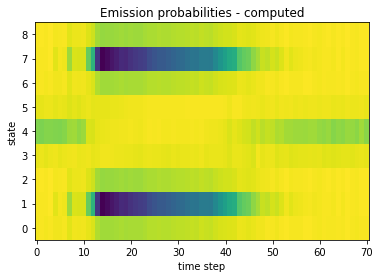

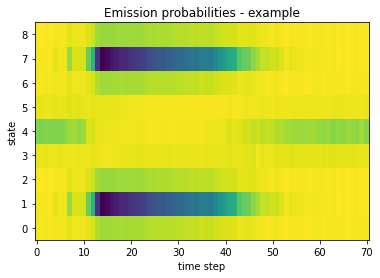

In [9]:
#@title Emission probabilities

##############################
# 5.1 Emission probabilities #
##############################

def log_multivariate_normal_density_diag(X, means, covars):
    """Compute Gaussian log-density at X for a diagonal model

    Args:
        X: array like, shape (n_observations, n_features)
        means: array like, shape (n_components, n_features)
        covars: array like, shape (n_components, n_features)

    Output:
        lpr: array like, shape (n_observations, n_components)
    From scikit-learn/sklearn/mixture/gmm.py
    """
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr

wordHMM = wordHMMs_onespkr[example['digit']]
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMM['means'], wordHMM['covars'])

plt.figure()
pcolormesh(obsloglik, 'Emission probabilities - computed')
plt.figure()
pcolormesh(example['obsloglik'], 'Emission probabilities - example')

Log-likelihood, computed (forward): -5970.427602563561
Log-likelihood, example: -5970.427602563561

Accuracy, training on one speaker: 77.3%
Accuracy, training on all speakers: 97.7%



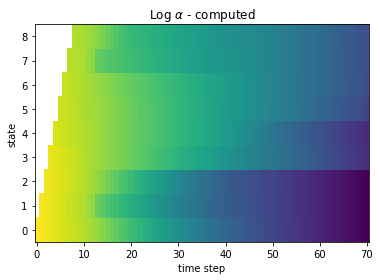

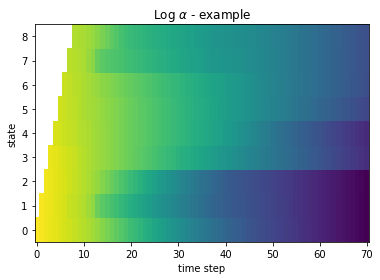

In [10]:
#@title Forward algorithm

#########################
# 5.2 Forward algorithm #
#########################

def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    log_alpha = np.zeros(log_emlik.shape)
    log_startprob = log_startprob[:-1]      # remove non-emitting state
    log_transmat = log_transmat[:-1, :-1]

    log_alpha[0] = log_startprob + log_emlik[0]
    for n in range(1, len(log_emlik)):
        log_alpha[n] = logsumexp(log_alpha[n-1].reshape(-1, 1) + log_transmat) + log_emlik[n]

    loglik = logsumexp(log_alpha[-1])
    return log_alpha, loglik

def score_recognizer(wordHMMs, data, viterbi_approx=False):
    accuracy = 0

    for utterance in data:
        best_loglik = np.NINF

        for word, wordHMM in wordHMMs.items():
            obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMM['means'], wordHMM['covars'])

            if viterbi_approx:
                loglik = viterbi(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))[0]
            else:
                loglik = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))[1]

            if loglik > best_loglik:
                best_loglik = loglik
                recognized_word = word

        if utterance['digit'] == recognized_word:
            accuracy += 1

    accuracy /= len(data)
    return accuracy

logalpha, loglik = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))

plt.figure()
pcolormesh(logalpha, r'Log $\alpha$ - computed')
plt.figure()
pcolormesh(example['logalpha'], r'Log $\alpha$ - example')

print('Log-likelihood, computed (forward):', loglik)
print('Log-likelihood, example:', example['loglik'])
print()

print('Accuracy, training on one speaker: {:.1f}%'.format(100 * score_recognizer(wordHMMs_onespkr, data)))
print('Accuracy, training on all speakers: {:.1f}%'.format(100 * score_recognizer(wordHMMs_all, data)))
print()

Viterbi log-likelihood, computed: -5974.211288357338
Viterbi log-likelihood, example: -5974.211288357338

Accuracy with Viterbi approximation, training on one speaker: 77.3%
Accuracy with Viterbi approximation, training on all speakers: 100.0%

Time elapsed with forward: 5.32 s
Time elapsed with Viterbi: 2.83 s



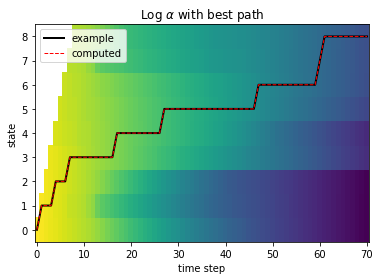

In [11]:
#@title Viterbi approximation

import timeit

#############################
# 5.3 Viterbi approximation #
#############################

def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    N, M = log_emlik.shape
    logV = np.zeros((N, M))
    B = np.zeros((N, M), dtype='uint32')    # the first row is not used but kept for simplicity
    log_startprob = log_startprob[:-1]      # remove non-emitting state
    log_transmat = log_transmat[:-1, :-1]

    logV[0] = log_startprob + log_emlik[0]
    for n in range(1, len(log_emlik)):
        aux = logV[n - 1].reshape(-1, 1) + log_transmat
        logV[n] = np.max(aux, axis=0) + log_emlik[n]
        B[n] = np.argmax(aux, axis=0)
    viterbi_loglik = np.max(logV[-1])

    # backtracking
    viterbi_path = np.zeros(N, dtype='uint32')
    if forceFinalState:
        viterbi_path[-1] = M-1
    else:
        viterbi_path[-1] = np.argmax(logV[-1])
    for n in range(N-2, -1, -1):
        viterbi_path[n] = B[n+1, viterbi_path[n+1]]

    return viterbi_loglik, viterbi_path

vloglik, vpath = viterbi(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))

print('Viterbi log-likelihood, computed:', vloglik)
print('Viterbi log-likelihood, example:', example['vloglik'])
print()

print('Accuracy with Viterbi approximation, training on one speaker: {:.1f}%'
      .format(100 * score_recognizer(wordHMMs_onespkr, data, viterbi_approx=True)))
print('Accuracy with Viterbi approximation, training on all speakers: {:.1f}%'
      .format(100 * score_recognizer(wordHMMs_all, data, viterbi_approx=True)))
print()

# alphas overlaid by best best
plt.figure()
pcolormesh(logalpha, r'Log $\alpha$ with best path')
plt.plot(np.arange(len(vpath)) + .5, example['vpath'] + .5, 'k', linewidth=2, label='example')
plt.plot(np.arange(len(vpath)) + .5, vpath + .5, 'r--', linewidth=1, label='computed')
plt.legend()

# efficiency forward vs Viterbi
t_forward = timeit.default_timer()
score_recognizer(wordHMMs_onespkr, data)
score_recognizer(wordHMMs_all, data)
t_forward = timeit.default_timer() - t_forward

t_viterbi = timeit.default_timer()
score_recognizer(wordHMMs_onespkr, data, viterbi_approx=True)
score_recognizer(wordHMMs_all, data, viterbi_approx=True)
t_viterbi = timeit.default_timer() - t_viterbi

print('Time elapsed with forward: {:.2f} s'.format(t_forward))
print('Time elapsed with Viterbi: {:.2f} s'.format(t_viterbi))
print()

Log-likelihood, computed (backward): -5970.427602563565
Log-likelihood, example: -5970.427602563561



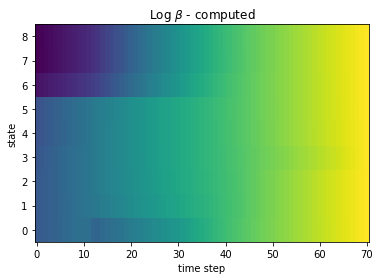

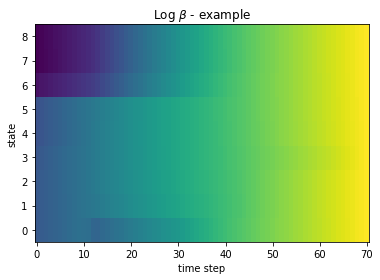

In [12]:
#@title Backward algorithm

##########################
# 5.4 Backward algorithm #
##########################

def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """
    log_beta = np.zeros(log_emlik.shape)
    log_startprob = log_startprob[:-1]  # remove non-emitting state
    log_transmat = log_transmat[:-1, :-1]

    log_beta[-1] = 0
    for n in range(len(log_emlik)-2, -1, -1):
        log_beta[n] = logsumexp(log_transmat + log_emlik[n+1] + log_beta[n+1], axis=1)

    loglik = logsumexp(log_emlik[0] + log_beta[0] + log_startprob)
    return log_beta, loglik

logbeta, loglik = backward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))

plt.figure()
pcolormesh(logbeta, r'Log $\beta$ - computed')
plt.figure()
pcolormesh(example['logbeta'], r'Log $\beta$ - example')

print('Log-likelihood, computed (backward):', loglik)
print('Log-likelihood, example:', example['loglik'])
print()

Sum of posteriors along time axis:
 [ 1.34597458  2.09555994  3.55849998  9.73752276 10.12040999 20.5329264
 12.9968938   1.20869929  9.40351326]

Sum of all posteriors: 71.00
Length of observation sequence: 71



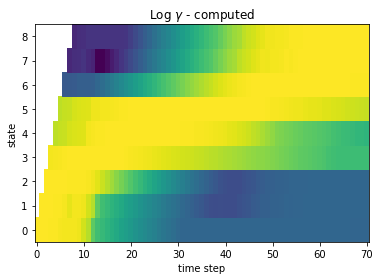

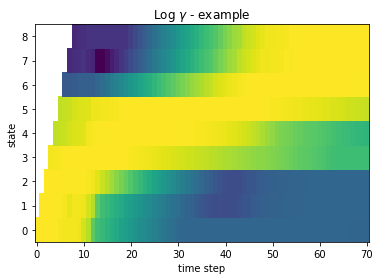

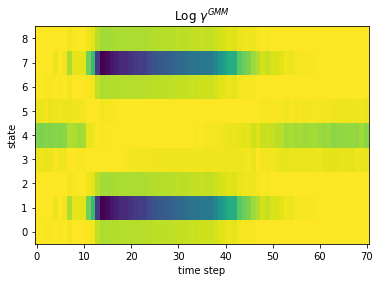

In [13]:
#@title State posteriors

########################
# 6.1 State posteriors #
########################

def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[-1])
    return log_gamma

loggamma = statePosteriors(logalpha, logbeta)

plt.figure()
pcolormesh(loggamma, r'Log $\gamma$ - computed')
plt.figure()
pcolormesh(example['loggamma'], r'Log $\gamma$ - example')

# row-stochastic
if not all(np.isclose(np.exp(logsumexp(loggamma, axis=1)), 1)):
    raise ValueError('log_gamma is not row-stochastic.')

# GMMs vs HMMs
loggamma_gmm = obsloglik - logsumexp(obsloglik, axis=1).reshape(-1, 1)
plt.figure()
pcolormesh(loggamma_gmm, r'Log $\gamma^{GMM}$')

# sum of posteriors along time axis
print('Sum of posteriors along time axis:\n', np.exp(logsumexp(loggamma)))
print()

# sum of all posteriors vs length of observation sequence
print('Sum of all posteriors: {:.2f}'.format(np.exp(logsumexp(logsumexp(loggamma)))))
print('Length of observation sequence: {}'.format(len(obsloglik)))
print()

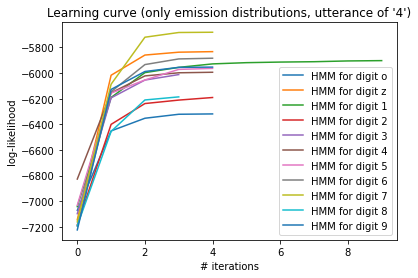

In [14]:
#@title Retraining emission distributions

#########################################
# 6.2 Retraining emission distributions #
#########################################

def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """
    N, D = X.shape
    M = log_gamma.shape[1]
    means = np.zeros((M, D))
    covars = np.zeros((M, D))

    for j in range(M):
        means[j] = np.sum(np.exp(log_gamma[:, j]) * X.T, axis=1) / np.exp(logsumexp(log_gamma[:, j]))
        covars[j] = np.sum(np.exp(log_gamma[:, j]) * (X - means[j]).T ** 2, axis=1) / np.exp(logsumexp(log_gamma[:, j]))
        covars[covars < varianceFloor] = varianceFloor
    return means, covars

def retrain_emission_distributions(utterance, wordHMM, maxiter=20, threshold=1.0):
    loglik = []

    for i in range(maxiter):
        # E-step
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMM['means'], wordHMM['covars'])
        logalpha, loglik_ = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        logbeta = backward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))[0]
        loggamma = statePosteriors(logalpha, logbeta)

        # check termination (here to avoid running forward() two times per iteration)
        if i > 0 and abs(loglik_ - loglik[-1]) < threshold:
            break
        loglik.append(loglik_)

        # M-step
        wordHMM['means'], wordHMM['covars'] = updateMeanAndVar(utterance['lmfcc'], loggamma)

    return loglik

plt.figure()
utterance = data[10]
# for word in ['1', '4', '9']:
for word, wordHMM in wordHMMs_all.items():
    wordHMM = wordHMM.copy()
    loglik = retrain_emission_distributions(utterance, wordHMM)

    plt.plot(loglik, label='HMM for digit {}'.format(word))
    plt.xlabel('# iterations')
    plt.ylabel('log-likelihood')
    plt.title("Learning curve (only emission distributions, utterance of '{}')".format(utterance['digit']))
plt.legend()
